In [81]:
import requests
from requests.auth import HTTPDigestAuth
import numpy as np
import cv2
from PIL import Image
import json
from cnstd import CnStd
from cnocr import CnOcr
std = CnStd(context="cpu",)
cn_ocr = CnOcr(context="cpu")
# Parámetros del DVR
ip_dvr = "192.168.0.249"
usuario = "admin"
contrasena = "asd12345"
canal = 5  # Por ejemplo: canal 1 -> 101

# URL del snapshot



url = f"http://{ip_dvr}/ISAPI/Streaming/channels/{canal}01/picture?videoResolutionWidth=1920&videoResolutionHeight=1080"
#url = f"http://{ip_dvr}/ISAPI/Streaming/channels/{canal}01/picture"
try:
    response = requests.get(url, auth=HTTPDigestAuth(usuario, contrasena), timeout=5)

    if response.status_code == 200:
        # Convertir bytes a imagen con OpenCV
        img_array = np.frombuffer(response.content, dtype=np.uint8)
        imgen_read = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        imgen_read = cv2.cvtColor(imgen_read,cv2.COLOR_BGR2RGB)
        


        if imgen_read is not None:
            print("imagen guardada")
            print(imgen_read.shape)
        else:
            print("❌ No se pudo decodificar la imagen.")
    else:
        print(f"❌ Error al obtener imagen: {response.status_code}")
except Exception as e:
    print(f"❌ Excepción: {e}")



[INFO] 2025-07-02 17:29:39,983 [RapidOCR] base.py:24: Using engine_name: onnxruntime
[INFO] 2025-07-02 17:29:39,984 [RapidOCR] main.py:55: Using C:\Users\jeff_\AppData\Roaming\cnstd\1.2\ppocr\ch_PP-OCRv5_det\ch_PP-OCRv5_det_infer.onnx
[INFO] 2025-07-02 17:29:40,074 [RapidOCR] base.py:24: Using engine_name: onnxruntime
[INFO] 2025-07-02 17:29:40,075 [RapidOCR] main.py:55: Using C:\Users\jeff_\AppData\Roaming\cnstd\1.2\ppocr\ch_PP-OCRv4_det\ch_PP-OCRv4_det_infer.onnx


imagen guardada
(1080, 1920, 3)



0: 384x640 None23.3ms
Speed: 3.5ms preprocess, 23.3ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)
[2, 3]


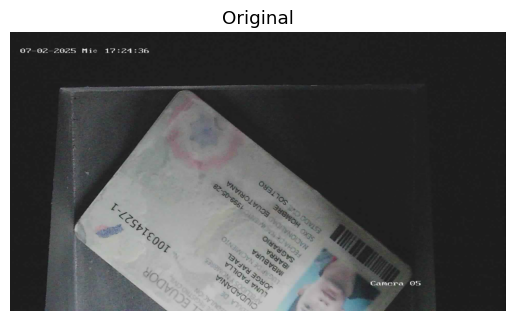

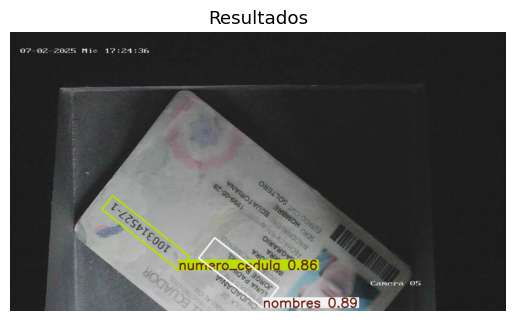

In [82]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

model_yolo = YOLO(
    "../MiCasitaCIDetection/runs/obb/yolo11_obb_custom4/weights/best.pt"
)  # Cambia por "runs/detect/train/weights/best.pt" 

results = model_yolo(imgen_read,conf=0.8)
# Mostrar resultados usando PIL
for result in results:
    clas=[int(cls) for cls in result.obb.cls.int()]
    print(clas)
    img_array = result.plot()[:, :, ::-1]
    img_array= cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
    points=result.obb.xyxyxyxy.cpu().numpy()
    %matplotlib inline
    plt.imshow(imgen_read)
    plt.axis('off')
    plt.title("Original")
    plt.show()

    plt.imshow(img_array)
    plt.axis('off')
    plt.title("Resultados")
    plt.show()

In [83]:
import cv2
import numpy as np
import math

def rotar_imagen_cv2(img, angulo):
    """
    Rota una imagen con OpenCV alrededor del centro manteniendo el tamaño original.

    Args:
        img (np.ndarray): Imagen cargada con cv2.
        angulo (float): Ángulo de rotación en grados (positivo: antihorario).

    Returns:
        np.ndarray: Imagen rotada con tamaño original.
    """
    (h, w) = img.shape[:2]
    centro = (w // 2, h // 2)

    # Matriz de rotación
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)

    # Aplicar rotación sin cambiar tamaño
    img_rotada = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=0)

    return img_rotada

import cv2
import numpy as np
import math

def recorte_desde_4_puntos(imagen, puntos, scale=1.0):
    """
    Recorta una región rectangular dada por 4 puntos, la alinea horizontalmente,
    la rota si está en vertical (para que quede a lo largo),
    y devuelve la imagen recortada, el ángulo original y el ángulo corregido.

    Args:
        imagen (np.ndarray): Imagen de entrada.
        puntos (list): Lista de 4 puntos [[x1, y1], [x2, y2], [x3, y3], [x4, y4]].
        scale (float): Escala del recorte.

    Returns:
        tuple: (imagen_recortada_horizontal, angulo_original, angulo_correccion)
            - angulo_original: ángulo antihorario respecto al eje X
            - angulo_correccion: 0 si no se rotó, 90 si se rotó para dejarlo horizontal
    """
    pts = np.array(puntos, dtype="float32")

    # Ordenar puntos: top-left, top-right, bottom-right, bottom-left
    def ordenar_puntos(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]     # top-left
        rect[2] = pts[np.argmax(s)]     # bottom-right

        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  # top-right
        rect[3] = pts[np.argmax(diff)]  # bottom-left
        return rect

    rect = ordenar_puntos(pts)
    (tl, tr, br, bl) = rect

    # Calcular dimensiones
    ancho_sup = np.linalg.norm(tr - tl)
    ancho_inf = np.linalg.norm(br - bl)
    max_ancho = int(max(ancho_sup, ancho_inf) * scale)

    alto_izq = np.linalg.norm(bl - tl)
    alto_der = np.linalg.norm(br - tr)
    max_alto = int(max(alto_izq, alto_der) * scale)

    # Calcular ángulo original en sentido antihorario desde el eje X
    dx = tr[0] - tl[0]
    dy = tr[1] - tl[1]
    angulo_rad = math.atan2(dy, dx)
    angulo_original = math.degrees(angulo_rad)

    # Crear matriz de destino para perspectiva (sin rotación)
    dst = np.array([
        [0, 0],
        [max_ancho - 1, 0],
        [max_ancho - 1, max_alto - 1],
        [0, max_alto - 1]
    ], dtype="float32")

    # Transformar la imagen
    M = cv2.getPerspectiveTransform(rect, dst)
    imagen_recortada = cv2.warpPerspective(imagen, M, (max_ancho, max_alto))

    # Verificar si está en vertical: alto > ancho
    if imagen_recortada.shape[0] > imagen_recortada.shape[1]:
        # Rotar 90° sentido horario
        imagen_recortada = cv2.rotate(imagen_recortada, cv2.ROTATE_90_CLOCKWISE)
        angulo_correccion = 90
    else:
        angulo_correccion = 0

    return imagen_recortada, angulo_original ,angulo_correccion





In [84]:
def equlizar_ycrcb(imgen):
    if imgen.ndim==2:
        return cv2.equalizeHist(imgen)
    if imgen.ndim==3:
        img_eq=cv2.cvtColor(imgen,cv2.COLOR_RGB2YCrCb)
        y,cr,cb=img_eq.transpose(2,0,1)
        y=cv2.equalizeHist(y)
        img_eq=cv2.merge((y,cr,cb))
        return cv2.cvtColor(img_eq,cv2.COLOR_YCR_CB2RGB)
    
def equlizar_hsv(imgen):
    if imgen.ndim==2:
        return cv2.equalizeHist(imgen)
    if imgen.ndim==3:
        img_eq=cv2.cvtColor(imgen,cv2.COLOR_RGB2HSV)
        h,s,v=img_eq.transpose(2,0,1)
        v=cv2.equalizeHist(v)
        img_eq=cv2.merge((h,s,v))
        return cv2.cvtColor(img_eq,cv2.COLOR_HSV2RGB)

In [85]:
import torch

filtros_tensores = {
    "blur": torch.tensor(
        [[1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9], [1 / 9, 1 / 9, 1 / 9]],
        dtype=torch.float32,
    ),
    "gaussian": torch.tensor([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=torch.float32)
    / 16,
    "sobel_x": torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32),
    "sobel_y": torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32),
    "scharr_x": torch.tensor(
        [[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]], dtype=torch.float32
    ),
    "laplacian": torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32),
    "prewitt_x": torch.tensor(
        [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=torch.float32
    ),
    "unsharp_mask": torch.tensor(
        [[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=torch.float32
    ),
    "sharpen_strong": torch.tensor(
        [[0, -1, 0], [-1, 9, -1], [0, -1, 0]], dtype=torch.float32
    ),
    "emboss": torch.tensor([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]], dtype=torch.float32),
    "edge_enhance": torch.tensor(
        [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float32
    ),
    "erosion": torch.ones((3, 3), dtype=torch.float32),
}

import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

def aplicar_filtro(imagen, kernel):
    # imagen: Tensor (1, 1, H, W)
    # kernel: Tensor (3, 3)
    kernel = kernel.unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, 3, 3)
    return F.conv2d(imagen, kernel, padding=1)

(100, 313, 3)
(68, 378, 3)


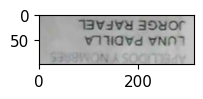

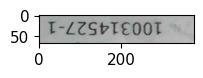

In [86]:
recortado_rotado = []
#img_eq=cv2.cvtColor(imgen_read,cv2.COLOR_RGB2GRAY)
#img_eq=equlizar_ycrcb(imgen_read)
img_eq=imgen_read
for point in points:
    img_result, angle_ori,angle_corr = recorte_desde_4_puntos(img_eq, point)
    print(img_result.shape)
    
    # Convertir a tensor y agregar dimensiones de batch y canal
    #img_tensor = torch.from_numpy(img_result).float().unsqueeze(0).unsqueeze(0)
    #img_tensor = img_tensor / 255.0  # Normalizar si es necesario
#
    ## Asegúrate de que img_tensor esté en el mismo device que el kernel
    #img_tensor = img_tensor.to(device)
#
    #img_tensor = aplicar_filtro(img_tensor, filtros_tensores["gaussian"])
    #img_tensor = aplicar_filtro(img_tensor, filtros_tensores["blur"])
    #
    ## Quitar dimensiones extra y convertir de nuevo a numpy
    #img_result = img_tensor.squeeze().cpu().numpy()
    #img_result = (img_result * 255).clip(0, 255).astype("uint8")  # Volver a uint8

    #umbral = int(np.mean(img_result))
    #_, img_result = cv2.threshold(img_result, umbral, 255, cv2.THRESH_BINARY)
    #img_result = equlizar_ycrcb(img_result)
    #img_result=equlizar_hsv(img_result)
    recortado_rotado.append(img_result)
for plot in recortado_rotado:
    plt.figure(figsize=(2, 2))
    plt.imshow(plot,cmap="gray")

In [87]:
def rellenar_con_fondo(imagen, nuevo_ancho, nuevo_alto, color_fondo=(255, 255, 255)):
    """
    Rellena una imagen con un fondo de color blanco (o el color especificado) hasta alcanzar las dimensiones deseadas.
    Si la imagen es más grande que el fondo, la redimensiona para que quepa.

    Args:
        imagen (np.ndarray): Imagen original (puede ser en escala de grises o color).
        nuevo_ancho (int): Ancho deseado de salida.
        nuevo_alto (int): Alto deseado de salida.
        color_fondo (tuple): Color de fondo (por defecto blanco).

    Returns:
        np.ndarray: Imagen con fondo centrado del tamaño especificado.
    """
    alto_ori, ancho_ori = imagen.shape[:2]

    # Si la imagen es más grande que el fondo, redimensionar para que quepa
    scale = min(nuevo_ancho / ancho_ori, nuevo_alto / alto_ori, 1.0)
    if scale < 1.0:
        new_size = (int(ancho_ori * scale), int(alto_ori * scale))
        imagen = cv2.resize(imagen, new_size, interpolation=cv2.INTER_AREA)
        alto_ori, ancho_ori = imagen.shape[:2]

    # Crear fondo
    if len(imagen.shape) == 2:  # Escala de grises
        fondo = np.full((nuevo_alto, nuevo_ancho), color_fondo[0], dtype=np.uint8)
    else:  # Color
        fondo = np.full((nuevo_alto, nuevo_ancho, 3), color_fondo, dtype=np.uint8)

    # Calcular desplazamientos para centrar
    x_offset = (nuevo_ancho - ancho_ori) // 2
    y_offset = (nuevo_alto - alto_ori) // 2

    # Insertar la imagen original centrada
    fondo[y_offset:y_offset+alto_ori, x_offset:x_offset+ancho_ori] = imagen

    return fondo

(32, 210, 3)
ocr result: {'text': 'LUNA PADILLA', 'score': 0.7487657070159912}
(31, 220, 3)
ocr result: {'text': 'ORGE RAFAA.', 'score': 0.45984548330307007}


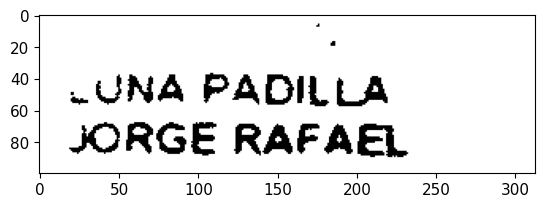

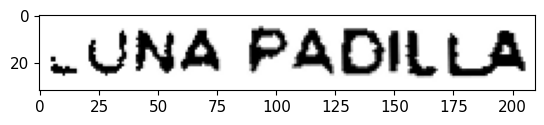

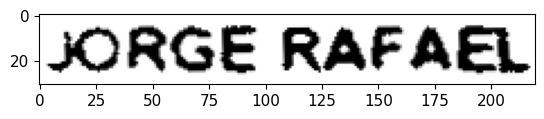

In [91]:
img_pr = rotar_imagen_cv2(recortado_rotado[0], 180)
img_pr=cv2.cvtColor(img_pr,cv2.COLOR_RGB2GRAY)
umbral = int(np.mean(img_pr))
_, img_pr = cv2.threshold(img_pr, 127, 255, cv2.THRESH_BINARY)
img_pr=cv2.cvtColor(img_pr,cv2.COLOR_GRAY2RGB)
plt.figure()
plt.imshow(img_pr)
box_infos = std.detect(img_pr)
for box_info in box_infos["detected_texts"]:
    cropped_img = box_info["cropped_img"]
    plt.figure()
    plt.imshow(cropped_img)
    print(cropped_img.shape)
    ocr_res = cn_ocr.ocr_for_single_line(cropped_img)
    print("ocr result: %s" % str(ocr_res))